In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
datadir

'../data'

In [3]:
p="/data/projects/robin/ANCA/Visium_ANCA/data/healthy_ref_external/counts/"
external_ctrl_samples = [os.path.join(p, file) for file in os.listdir(p) if "." in file]

In [4]:
all_samples = external_ctrl_samples

In [5]:
from tqdm import tqdm

In [6]:
batch_key = "Sample"

In [7]:
i=0
for sample in tqdm(all_samples):
    if "_filtered" in sample:
        tmp = sc.read_10x_h5(sample)
        tmp.var_names_make_unique()
        sample_name = sample.split("/")[-1].split(".")[0].split("_filtered")[0]
        tmp.obs[batch_key] = sample_name
        sample = sample_name
        tmp.obs.index = [idx+"_{}".format(sample_name) for idx in tmp.obs.index]
        if i==0:
            adata = tmp
            i=1
        else:
            adata = adata.concatenate(tmp, uns_merge="unique", index_unique=None)

adata.obs = adata.obs[[col for col in adata.obs.columns if col!="batch"]]

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
 20%|██        | 1/5 [00:00<00:01,  2.60it/s]/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
 40%|████      | 2/5 [00:01<00:01,  1.87it/s]/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_name

In [8]:
adata.raw = adata.copy()

In [9]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], 
                                                                adata.obs.Sample.unique().shape[0])

'No. of spots: 12410, No. of genes: 36601, No. of samples: 5'

In [10]:
target_sum=1e4
min_genes=100
min_spots=3
n_comps=50
n_neighbors=10
use_highly_variable=True
mt_cutoff=20
min_counts=500
max_counts=35000

In [11]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

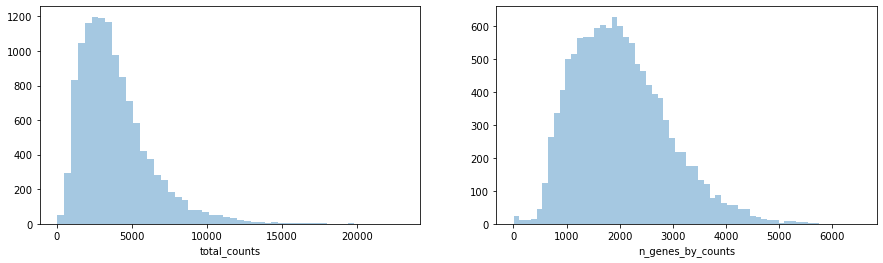

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])


In [13]:
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)
sc.pp.filter_genes(adata, min_cells=min_spots)

In [14]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], 
                                                                adata.obs.Sample.unique().shape[0])

'No. of spots: 12355, No. of genes: 21830, No. of samples: 5'

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

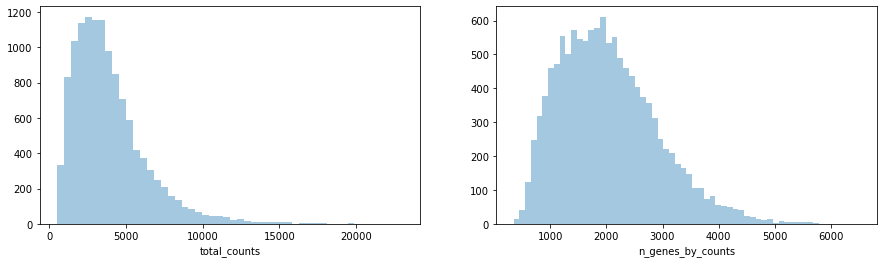

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])


In [16]:
adata.obs["Condition"] = "CTRL"

In [17]:
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, batch_key="Sample")

In [19]:
sc.tl.pca(adata, random_state=seed, use_highly_variable=True, n_comps=50)

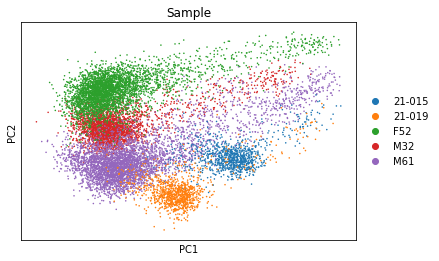

In [20]:
sc.pl.pca(adata, color="Sample")

In [21]:
adata.write(os.path.join(datadir, "external_ctrl_samples_processed.h5ad"))

In [22]:
adata.shape

(12355, 21830)